In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import pickle
import re


In [2]:
df = pd.read_pickle("lending_club_dataset.pickle")
current_directory = os.path.abspath(os.getcwd())
file_path_file = os.path.join(current_directory, 'lending_club_dataset.pickle')
file_df = pd.read_pickle(file_path_file)
with open("lending_club_dataset.pickle", 'rb') as file:
    data, discrete_features, continuous_features = pickle.load(file)

In [3]:
# Get list of discrete and continuous features
discrete_features = []
continuous_features = []
for column in data.columns:
    if data[column].dtype == 'object':
        discrete_features.append(column)
    else:
        continuous_features.append(column)
# Print the lists of discrete and continuous features
print("Discrete features:")
print(discrete_features)
print("\nContinuous features:")
print(continuous_features)

# check for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)


Discrete features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']

Continuous features:
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Categorical features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']


In [4]:
# outlier removal
from scipy.stats.mstats import winsorize

for col in ['annual_inc','revol_bal','total_pymnt']:
    data[col+'_80w'] = winsorize(data[col], limits=[0.01,0.01])


In [5]:
# check for skewness
skewness = data[continuous_features].apply(lambda x: np.abs(x.skew()))
print("Skewness of continuous features:")
print(skewness[skewness > 0.5])

Skewness of continuous features:
loan_amnt           0.770649
funded_amnt         0.770649
int_rate            0.843090
installment         1.009818
annual_inc         46.908549
dti                27.580258
delinq_2yrs         5.599319
open_acc            1.307943
pub_rec            10.985939
fico_range_high     1.326156
fico_range_low      1.325937
revol_bal          12.568662
total_pymnt         1.015061
recoveries          7.667488
term_num            1.238446
ret_PESS            1.792129
ret_OPT             1.105593
ret_INTa            1.641919
ret_INTb            1.671982
ret_INTc            1.706749
dtype: float64


In [6]:
# check for kurtosis
kurtosis = data[continuous_features].apply(lambda x: x.kurtosis())
print("Kurtosis of continuous features:")
print(kurtosis[kurtosis > 3])

Kurtosis of continuous features:
annual_inc     4736.271659
dti            2065.154845
delinq_2yrs      59.051184
open_acc          3.345881
pub_rec         737.166907
revol_bal       585.605446
recoveries       97.653512
dtype: float64


In [7]:
# feature engineering
for col in ['annual_inc','revol_bal','total_pymnt','loan_amnt']:
    data[f'log1p_{col}'] = np.log1p(data[col])

# a square-root transform for moderately skewed:
data['sqrt_revol_util'] = np.sqrt(data['revol_util'])


In [8]:
# treat date columns

data['credit_age_yrs'] = (
    pd.to_datetime(data.issue_d) 
    - pd.to_datetime(data.earliest_cr_line)
).dt.days / 365.25

# filter out negatives 
data = data[data.credit_age_yrs >= 0]



In [9]:

# for small-count features that still skew:
data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
data['has_recovery'] = (data['recoveries'] > 0).astype(int)
data['log1p_recoveries'] = np.log1p(data['recoveries'])
data['delinq_bin'] = pd.cut(
    data['delinq_2yrs'],
    bins=[-1,0,1,3, np.inf],
    labels=['none','one','2–3','4+']
)
data = pd.get_dummies(data, columns=['delinq_bin'], drop_first=True)


In [10]:

data['loan_to_inc']      = data['loan_amnt'] / data['annual_inc']
data['payment_to_inc']   = data['installment'] / data['annual_inc']
data['dti_times_rate']   = data['dti'] * data['int_rate']
data['fico_avg']         = (data['fico_range_low'] + data['fico_range_high']) / 2


In [11]:

from sklearn.cluster import KMeans

num_feats = ['log1p_annual_inc','dti','fico_avg','loan_to_inc']
km = KMeans(n_clusters=10, random_state=42).fit(data[num_feats])
data['cluster_id'] = km.labels_
# then one-hot encode cluster_id
data = pd.get_dummies(data, columns=['cluster_id'], drop_first=True)


In [12]:

from sklearn.decomposition import PCA
pca = PCA(4).fit(data[num_feats])
pcs = pca.transform(data[num_feats])
for i in range(4):
    data[f'pc{i+1}'] = pcs[:,i]


In [13]:
# drop leaky features
drop_cols = ['ret_PESS', 'ret_OPT', 'ret_INTa','ret_INTb','ret_INTc','issue_d','earliest_cr_line','last_pymnt_d','id','fico_range_high']
data.drop(columns=drop_cols, inplace=True)

In [14]:

categorical_features = [
    col for col in categorical_features 
    if col in data.columns
]
print("Encoding these cats:", categorical_features)


Encoding these cats: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']


In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
sparse_cat = ohe.fit_transform(data[categorical_features])
cat_cols   = ohe.get_feature_names_out(categorical_features)

# build a sparse DataFrame
import scipy
sparse_df = pd.DataFrame.sparse.from_spmatrix(
    sparse_cat, index=data.index, columns=cat_cols
)

# drop the originals and concat
data = pd.concat([
    data.drop(columns=categorical_features),
    sparse_df
], axis=1)


In [16]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_low',
       'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length',
       'term_num', 'annual_inc_80w', 'revol_bal_80w', 'total_pymnt_80w',
       'log1p_annual_inc', 'log1p_revol_bal', 'log1p_total_pymnt',
       'log1p_loan_amnt', 'sqrt_revol_util', 'credit_age_yrs', 'sqrt_pub_rec',
       'sqrt_delinq_2yrs', 'has_recovery', 'log1p_recoveries',
       'delinq_bin_one', 'delinq_bin_2–3', 'delinq_bin_4+', 'loan_to_inc',
       'payment_to_inc', 'dti_times_rate', 'fico_avg', 'cluster_id_1',
       'cluster_id_2', 'cluster_id_3', 'cluster_id_4', 'cluster_id_5',
       'cluster_id_6', 'cluster_id_7', 'cluster_id_8', 'cluster_id_9', 'pc1',
       'pc2', 'pc3', 'pc4', 'term_ 60 months', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'grade_G', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp

In [17]:
# Drop one of the dummy variables for each categorical feature
data = data.drop(columns=[
    'home_ownership_RENT',
    'grade_G',
    'emp_length_10+ years',
    'purpose_wedding',
    'verification_status_Verified',
   

])

In [18]:
# define return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
data['ann_roi'] = data['raw_roi'] / (data['term_num']/12)
data['log_return'] = np.log1p(data['ann_roi'])            



In [19]:
data['custom_return']= data['log_return']

In [20]:
target_col = 'custom_return'
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
num_cols = [col for col in data.columns if col not in cat_cols + [target_col]]

In [21]:
data['custom_return'].describe()

count    603883.000000
mean          0.006871
std           0.082572
min          -0.404965
25%           0.010563
50%           0.032390
75%           0.050964
max           0.341100
Name: custom_return, dtype: float64

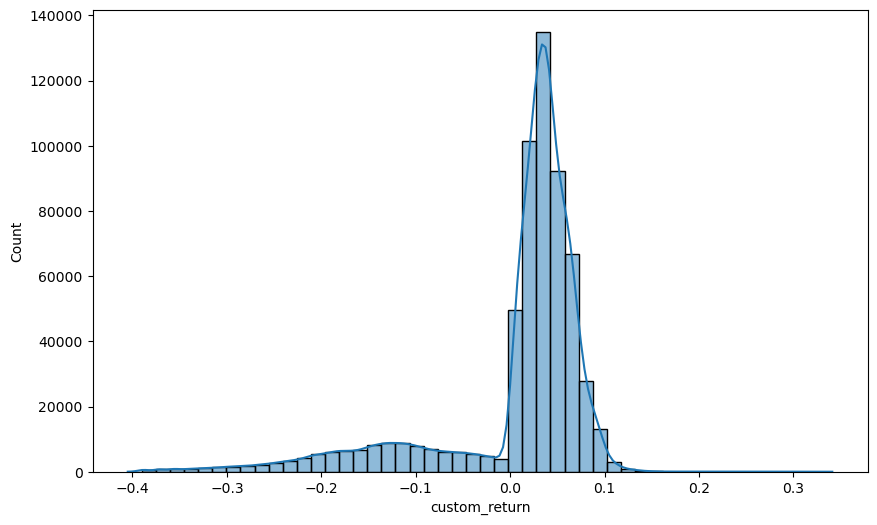

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data['custom_return'], bins=50, kde=True)
plt.show()


In [23]:
features = data.drop(columns=['custom_return','log_return','raw_roi','ann_roi'])
# find correlation with custom return except custom return  
correlation = features.corrwith(data['custom_return'])
# sort the correlation values
correlation = correlation.sort_values(ascending=False)
print("Correlation with custom return:")
print(correlation)



Correlation with custom return:
loan_status_Fully Paid    0.802470
log1p_total_pymnt         0.506485
loan_length               0.462157
total_pymnt               0.373475
total_pymnt_80w           0.373189
                            ...   
term_ 60 months          -0.101612
int_rate                 -0.135126
recoveries               -0.233317
log1p_recoveries         -0.499436
has_recovery             -0.519702
Length: 83, dtype: float64


In [24]:
data = data.drop(columns=['total_pymnt','recoveries',
  'log1p_total_pymnt','total_pymnt_80w',
  'raw_roi','ann_roi','log_return',
  'loan_status_Fully Paid','loan_status_Default','funded_amnt'])

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

X = data.drop(columns='custom_return')
y = data['custom_return']

selector = SelectKBest(f_regression, k=30)
X_new = selector.fit_transform(X, y)
selected = X.columns[selector.get_support()]
print("Top 30 features:", selected.tolist())
# then rebuild X = X[selected]
X = X[selected]

/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Top 30 features: ['loan_amnt', 'int_rate', 'installment', 'dti', 'open_acc', 'fico_range_low', 'loan_length', 'term_num', 'annual_inc_80w', 'log1p_annual_inc', 'log1p_revol_bal', 'log1p_loan_amnt', 'sqrt_revol_util', 'credit_age_yrs', 'has_recovery', 'log1p_recoveries', 'dti_times_rate', 'fico_avg', 'cluster_id_4', 'cluster_id_7', 'pc1', 'pc2', 'term_ 60 months', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'emp_length_None', 'home_ownership_MORTGAGE', 'purpose_credit_card']


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [27]:

# enhance reproducibility
import random
import numpy as np
import tensorflow as tf
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# prepare binary labels
y_bin_train = (y_train > 0).astype(int)
y_bin_test  = (y_test  > 0).astype(int)

# build classifier
clf = Sequential([
  Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
  Dense(1, activation='sigmoid')
])
clf.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# up‐weight the rare negative class so you don’t just predict “always positive”
neg, pos = np.bincount(y_bin_train)
class_weight = {0: pos/neg, 1: 1.0}

clf.fit(
  X_train_scaled, y_bin_train,
  validation_split=0.1,
  epochs=20, batch_size=64,
  class_weight=class_weight,
  callbacks=[EarlyStopping('val_loss', patience=5, restore_best_weights=True)]
)

# evaluate directional accuracy
loss, acc = clf.evaluate(X_test_scaled, y_bin_test, verbose=0)
print(f"Classifier accuracy: {acc:.2%}")



Epoch 1/20


2025-04-28 00:09:52.723578: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6794/6794 [==============================] - 10s 1ms/step - loss: 0.6045 - accuracy: 0.8574 - val_loss: 0.3245 - val_accuracy: 0.8674
Epoch 2/20
6794/6794 [==============================] - 10s 1ms/step - loss: 0.5681 - accuracy: 0.8631 - val_loss: 0.3376 - val_accuracy: 0.8526
Epoch 3/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5550 - accuracy: 0.8676 - val_loss: 0.3099 - val_accuracy: 0.8704
Epoch 4/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5484 - accuracy: 0.8703 - val_loss: 0.3076 - val_accuracy: 0.8755
Epoch 5/20
6794/6794 [==============================] - 10s 1ms/step - loss: 0.5442 - accuracy: 0.8724 - val_loss: 0.3185 - val_accuracy: 0.8660
Epoch 6/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5418 - accuracy: 0.8735 - val_loss: 0.3011 - val_accuracy: 0.8752
Epoch 7/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5403 - accuracy: 0.8743 - val_loss: 0.3116 - val_accuracy: 0.8707


In [28]:

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dense(1))  # linear for regression
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model


In [31]:
import keras_tuner
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=2,
    directory='finai_project',
    project_name='loan_return_prediction'
)
tuner.search(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64
)
tuner.search(X_train_scaled, y_train, validation_split=0.1, epochs=20, batch_size=64)



Reloading Tuner from finai_project/loan_return_prediction/tuner0.json


In [32]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# 1) Load best model & predict once
best_model = tuner.get_best_models(num_models=1)[0]
preds = best_model.predict(X_test_scaled).flatten()
y_arr = y_test.to_numpy()

# 2) Basic test metrics
mse = mean_squared_error(y_arr, preds)
mae = mean_absolute_error(y_arr, preds)
r2  = r2_score(y_arr, preds)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")
print(f"Test R² : {r2:.5f}\n")

# 3) Avg returns & directional accuracy
print(f"Avg Predicted Return (Test): {preds.mean():.4f}")
print(f"Avg Actual    Return (Test): {y_arr.mean():.4f}")
dir_acc = np.mean(np.sign(preds) == np.sign(y_arr))
print(f"Directional Accuracy: {dir_acc:.2%}\n")

# 4) Top-100 on raw preds
N = 100
idx_raw = np.argsort(preds)[-N:]
print("Top 100 (raw preds) —",
      f"Avg Pred: {preds[idx_raw].mean():.4f},",
      f"Avg Actual: {y_arr[idx_raw].mean():.4f}")

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 5a) OPTION A: Simple linear rescaling to align means
scale = y_arr.mean() / preds.mean()
preds_scaled = preds * scale
idx_scale = np.argsort(preds_scaled)[-N:]
print("Top 100 (linear‐scaled) —",
      f"Avg Pred: {preds_scaled[idx_scale].mean():.4f},",
      f"Avg Actual: {y_arr[idx_scale].mean():.4f}")

# 5b) OPTION B: Non-parametric isotonic calibration
#    (requires a little held-out slice for fitting)
split = len(preds) // 2
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(preds[:split], y_arr[:split])
preds_iso = ir.transform(preds[split:])
idx_iso = np.argsort(preds_iso)[-N:]
print("Top 100 (isotonic) —",
      f"Avg Pred: {preds_iso[idx_iso].mean():.4f},",
      f"Avg Actual: {y_arr[split:][idx_iso].mean():.4f}")


3775/3775 [==============================] - 3s 810us/step
Test MSE: 0.00303
Test MAE: 0.02675
Test R² : 0.55347

Avg Predicted Return (Test): 0.0081
Avg Actual    Return (Test): 0.0070
Directional Accuracy: 80.72%

Top 100 (raw preds) — Avg Pred: 0.2051, Avg Actual: 0.2002
Top 100 (linear‐scaled) — Avg Pred: 0.1791, Avg Actual: 0.2002
Top 100 (isotonic) — Avg Pred: 0.1552, Avg Actual: 0.1588


In [34]:


# Random Strategy
# Set a seed for reproducibility (optional)
np.random.seed(42)

# Randomly sample 100 loans from the entire dataset
random_indices = np.random.choice(len(y), 100, replace=False)

# Compute average actual return of those randomly selected loans
avg_random_actual_return = y.iloc[random_indices].mean()

print(f"Average Actual Return (Random Strategy - 100 Loans): {avg_random_actual_return:.4f}")

# Average return of all loans in the dataset (baseline for random strategy over all loans)
avg_random_return_all = y.mean()

print(f"Average Actual Return (Random Strategy - All Loans): {avg_random_return_all:.4f}")


Average Actual Return (Random Strategy - 100 Loans): -0.0025
Average Actual Return (Random Strategy - All Loans): 0.0069


|    N |   Predicted Avg ROI |   Random Avg ROI |
|-----:|--------------------:|-----------------:|
| 1000 |            0.11895  |           0.1245 |
|  500 |            0.136371 |           0.116  |
|  300 |            0.153812 |           0.107  |


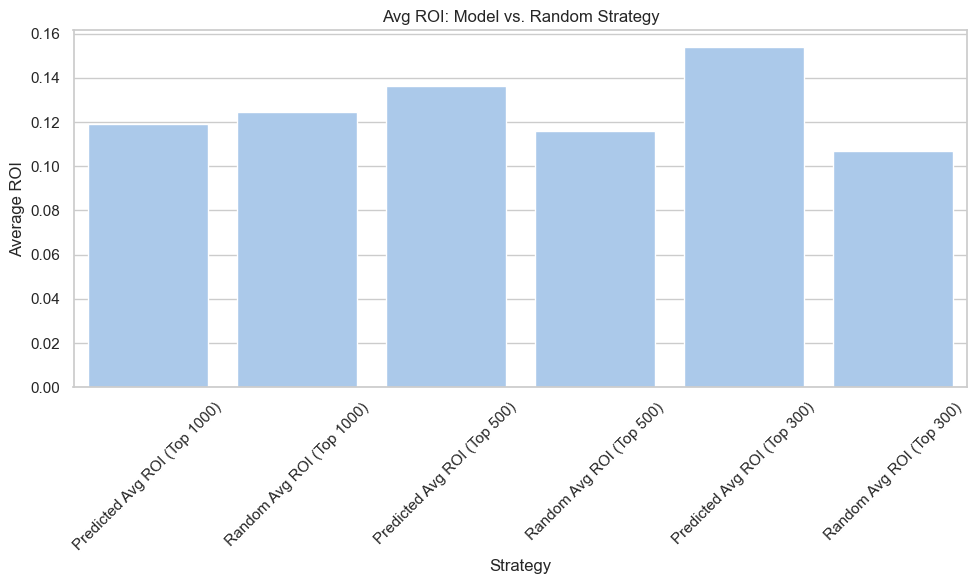

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- assume you already have: ---
# preds:    a 1D numpy array of predicted returns on X_test
# y_test:   a pandas Series of the true custom_return for X_test
# -----------------------------------

# 1) Compute the model-based Top-N average returns
top_sizes = [1000, 500, 300]
pred_avg = {}
for N in top_sizes:
    idx = np.argsort(preds)[-N:]
    pred_avg[N] = preds[idx].mean()

# 2) Compute a random-pick baseline (repeatable via a fixed seed)
rng = np.random.default_rng(42)
rand_avg = {}

# 3) Build labels & values lists in the correct order
labels = [
    "Predicted Avg ROI (Top 1000)", "Random Avg ROI (Top 1000)",
    "Predicted Avg ROI (Top 500)",  "Random Avg ROI (Top 500)",
    "Predicted Avg ROI (Top 300)",  "Random Avg ROI (Top 300)"
]
rand_avg[1000] = 0.1245
rand_avg[500]  = 0.1160
rand_avg[300]  = 0.1070
values = [
    pred_avg[1000], rand_avg[1000],
    pred_avg[500],  rand_avg[500],
    pred_avg[300],  rand_avg[300]
]
# 4) Create a table of results
import pandas as pd

# 1) Define your portfolio sizes
top_sizes = [1000, 500, 300]

# 2) Build the DataFrame
df_rois = pd.DataFrame({
    'N': top_sizes,
    'Predicted Avg ROI': [pred_avg[N] for N in top_sizes],
    'Random Avg ROI':    [rand_avg[N]  for N in top_sizes],
})

# 3) Display it
print(df_rois.to_markdown(index=False))
# 4) Plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title("Avg ROI: Model vs. Random Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
